In [1]:
import os, sys, csv, gzip
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy import io

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 ## Output Type 3 (Type3) or Type 42 (TrueType)
rcParams['font.sans-serif'] = 'Arial'
%matplotlib inline

from plots import COLORS10, enlarge_tick_fontsize
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.cross_validation import (StratifiedKFold, cross_val_score)
from sklearn.metrics import *
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble
from sklearn.pipeline import Pipeline
import xgboost as xgb

/Library/Python/2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# 1. Prepare the gene/feature attribute matrices and target class to for supervised machine learning

Load known Adhesome components from file

In [2]:
df_labels = pd.read_csv('../data/components.csv')
print df_labels.shape
df_labels.head()

(232, 7)


,Official Symbol,Gene ID,Protein name,Swiss-Prot ID,Synonyms,Functional Category,FA
0,ACTN1,87,Actinin,P12814,alpha-actinin,Actin regulation,Intrinsic Proteins
1,CFL1,1072,cofilin,P23528,CFL,Actin regulation,Intrinsic Proteins
2,CORO1B,57175,coronin 1B,Q9BR76,coronin-2,Actin regulation,Intrinsic Proteins
3,CTTN,2017,Cortactin,Q14247,"EMS1, Amplaxin",Actin regulation,Intrinsic Proteins
4,FLNA,2316,Filamin,P21333,"endothelial actin-binding protein, ABP-280, al...",Actin regulation,Intrinsic Proteins


These files below were downloaded from [Harmonizome](http://amp.pharm.mssm.edu/Harmonizome/) as the features for genes to predict whether they are adhesome components. 

There are two types datasets: continues and binary. Continues datasets were standardized.    

In [3]:
filenames = [
        'InterPro_gene_attribute_matrix.txt.gz', 
        'ENCODE-TF_gene_attribute_matrix.txt.gz',
        'CCLE-GE_gene_attribute_matrix_standardized.txt.gz',
        'Allen-adult-brain_gene_attribute_matrix_standardized.txt.gz',
        'Allen-dev-brain_gene_attribute_matrix_standardized.txt.gz'
    ]
basenames = [f.split('_')[0] for f in filenames]
are_continues = ['_standardized' in f for f in filenames]

In [4]:
def read_gene_attribute_matrix(fn):
	'''
	Reads a gzipped file downloaded from Harmonizome into a pandas.DataFrame,
	with GeneSym as index. 
	'''
	with gzip.open(fn) as f:
		reader = csv.reader(f, delimiter='\t')
		header = reader.next()
		header[0] = 'GeneSym'
		# Skip line 2, 3
		reader.next()
		reader.next()

		# Remove the second and third columns which are meta data for GeneSym
		header[1:3] = []

		i = 0
		df = []

		if '_standardized' in fn: # continues
			for row in reader:
				row[1:3] = []
				row[1:] = map(float, row[1:])
				df.append(dict(zip(header, row)))
				i += 1
				if i % 2000 == 0:
					print i
			df = pd.DataFrame().from_records(df)[header]
			df.set_index('GeneSym', inplace=True, verify_integrity=True)
					
		else: # convert values to int and make sparse df
			for row in reader:
				row[1:3] = []
				row[1:] = map(lambda x: int(float(x)), row[1:])

				d = {h: v for h, v in zip(header, row) if v != 0}
				df.append(d)
				i += 1
				if i % 2000 == 0:
					print i
			df = pd.DataFrame().from_records(df)[header]\
				.set_index('GeneSym', verify_integrity=True)\
				.to_sparse(fill_value=0)
		
	return df

In [5]:
## Parse data files downloaded from Harmonizome 
dfs = []
for fn in filenames:
    df = read_gene_attribute_matrix('../data/%s' % fn)
    print fn, df.shape
    dfs.append(df)

2000
4000
6000
8000
10000
12000
14000
16000
18000
InterPro_gene_attribute_matrix.txt.gz (18002, 11015)
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
ENCODE-TF_gene_attribute_matrix.txt.gz (22845, 1679)
2000
4000
6000
8000
10000
12000
14000
16000
18000
CCLE-GE_gene_attribute_matrix_standardized.txt.gz (18046, 1037)
2000
4000
6000
8000
10000
12000
14000
16000
Allen-adult-brain_gene_attribute_matrix_standardized.txt.gz (17979, 414)
2000
4000
6000
8000
10000
12000
14000
16000
Allen-dev-brain_gene_attribute_matrix_standardized.txt.gz (17241, 492)


In [6]:
## INNER JOIN all feature dfs 
df_joined = reduce(lambda a, b: pd.merge(a, b, left_index=True, right_index=True, how='inner'), 
           dfs)
print df_joined.shape

(13464, 14637)


In [7]:
## Create y 
RNG = 2016
y = np.in1d(df_joined.index, df_labels['Official Symbol']).astype(np.int8)
print y.sum()
## Make CV
cv = StratifiedKFold(y, n_folds=3, shuffle=True, random_state=RNG)
## Export y
df_labels = pd.DataFrame({'y': y, 'GeneSym': df_joined.index}).set_index('GeneSym')
print df_labels.shape
df_labels.to_csv('../data/Adhesomes.csv')
df_labels.head()

216
(13464, 1)


,y
GeneSym,
NUSAP1,0
WEE1,0
BUB1B,0
ASPM,0
TTK,0


In [8]:
## Keep only the shared genes across the 4 datasets
dfs = [df.ix[df_joined.index] for df in dfs]

In [9]:
## Export processed matrices in dfs
feature_names = {} # To store feature names
i = 0
for basename, df in zip(basenames, dfs):
    feature_names[basename] = df.columns.tolist()
    if are_continues[i]:
        np.save('../data/%s_shared' % basename, df.values)
    else: # sparse matrix
        io.mmwrite('../data/%s_shared.mtx' % basename, sp.csr_matrix(df.values))
    i += 1

del df_joined
del dfs, df

# 2. Load preprocessed matrices and perform classifications

In [10]:
# Load from matrices files generated above
Xs = []
for i, basename in enumerate(basenames):
    if are_continues[i]:
        Xs.append(np.load('../data/%s_shared.npy' % basename))
    else:
        Xs.append(io.mmread('../data/%s_shared.mtx' % basename).tocsr())

df_labels = pd.read_csv('../data/Adhesomes.csv')
y = df_labels['y'].values
ratio = float(np.sum(y == 0)) / np.sum(y==1)
print 'Number of known adhesome components: %d' % y.sum()
print 'Ratio of negative labels over positive labels: %.4f' % ratio

Number of known adhesome components: 216
Ratio of negative labels over positive labels: 61.3333


Perform dimentionality reduction using `TruncatedSVD` for all the matrices

In [11]:
all_loadings = [] # collect loading matrices from SVD
for i, basename in enumerate(basenames):
    svd = TruncatedSVD(n_components=60, random_state=RNG)
    Xs[i] = svd.fit_transform(Xs[i])
    all_loadings.append(svd.components_)

X_combined = np.hstack(Xs)

In [12]:
## Helper functions for evaluating classifiers
def cross_val_predictions(est, X, y, cv):
	'''to get out-of-sample predictions and scores'''
	y_preds = np.zeros(y.shape)
	y_probas = np.zeros(y.shape)
	for train_idx, valid_idx in cv:
		print X[train_idx].shape, y[train_idx].shape
		est.fit(X[train_idx], y[train_idx])
		y_preds[valid_idx] = est.predict(X[valid_idx])
		y_probas[valid_idx] = est.predict_proba(X[valid_idx])[:,1]
	return y_preds, y_probas


def plot_roc(ests, Xs, y, cv, ax, colors=None, labels=None):
	all_labels = []
	total = len(labels)

	if type(ests) == list and type(Xs) != list:
		total = len(ests)
		Xs = [Xs]*total
	elif type(ests) != list and type(Xs) == list:
		ests = [ests]*total
	
	for i in range(total):
		X = Xs[i]
		est = ests[i]
		
		label = labels[i]
		color = colors[i]
		all_labels.extend([label] * len(cv))

		y_preds, y_probas = cross_val_predictions(est, X, y, cv)
		fpr, tpr, _ = roc_curve(y, y_probas)
		score = auc(fpr, tpr)
		ax.plot(fpr, tpr, label=label + ' (AUC=%.3f)' % score, color=color, lw=2)

	ax.set_xlabel('False Positive Rate', fontsize=16)
	ax.set_ylabel('True Positive Rate', fontsize=16)

	enlarge_tick_fontsize(ax, 12)
	ax.legend(loc='lower right')
	return

Estimate the number of rounds of boosting using early stopping for a single feature matrix InterPro: The boosting classifier will stop if the validation score does not improve in 50 rounds.

In [13]:
dtrain = xgb.DMatrix(Xs[0], label=y)

param = {
    'max_depth':10, 'eta':0.05, 'silent':1, 'objective':'binary:logistic',
    'subsample': 0.4, 'colsample_bytree': 0.6,
    'min_child_weight': 50,
    'scale_pos_weight': ratio,
    'nthread': 6
}

num_round = 5000
scores = xgb.cv(param, dtrain, num_round, 
    folds=cv,
    early_stopping_rounds=50,
    metrics='auc', seed=RNG,
    verbose_eval=10)

print scores.tail()


[0]	train-auc:0.820459+0.0229896	test-auc:0.745151+0.0077069
[10]	train-auc:0.93892+0.0027836	test-auc:0.841864+0.0117731
[20]	train-auc:0.952989+0.0036986	test-auc:0.849968+0.00316156
[30]	train-auc:0.96102+0.00424137	test-auc:0.855808+0.00361613
[40]	train-auc:0.966086+0.00261812	test-auc:0.8555+0.00428185
[50]	train-auc:0.969816+0.0013973	test-auc:0.854981+0.00503997
[60]	train-auc:0.972845+0.00152091	test-auc:0.853563+0.00605039
[70]	train-auc:0.975211+0.0018458	test-auc:0.852767+0.00601178
[80]	train-auc:0.977073+0.00187863	test-auc:0.851972+0.00606561
    test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
35       0.856751      0.002450        0.963063       0.003304
36       0.856716      0.003180        0.963542       0.002999
37       0.856693      0.002257        0.964056       0.003098
38       0.855968      0.001767        0.964853       0.002845
39       0.856858      0.004342        0.965392       0.002660


Estimate the number of rounds of boosting using early stopping for the combined feature matrix.

In [14]:
dtrain = xgb.DMatrix(X_combined, label=y)

param = {
    'max_depth':12, 'eta':0.05, 'silent':1, 'objective':'binary:logistic',
    'subsample': 0.4, 'colsample_bytree': 0.4,
    'min_child_weight': 50,
    'scale_pos_weight': ratio,
    'nthread': 6
}

num_round = 5000
scores = xgb.cv(param, dtrain, num_round, 
    folds=cv,
    early_stopping_rounds=50,
    metrics='auc', seed=RNG,
    verbose_eval=10)

print scores.tail()


[0]	train-auc:0.81481+0.00187584	test-auc:0.72085+0.0264555
[10]	train-auc:0.964683+0.00209533	test-auc:0.845875+0.0139989
[20]	train-auc:0.979513+0.00218351	test-auc:0.855574+0.00475015
[30]	train-auc:0.987437+0.00264669	test-auc:0.857632+0.00750839
[40]	train-auc:0.991936+0.00301162	test-auc:0.856888+0.00569661
[50]	train-auc:0.994006+0.0026162	test-auc:0.856431+0.00527264
[60]	train-auc:0.99581+0.00202458	test-auc:0.854646+0.00611534
[70]	train-auc:0.99678+0.00180488	test-auc:0.857454+0.00583333
[80]	train-auc:0.997784+0.00116644	test-auc:0.859574+0.00635607
[90]	train-auc:0.998488+0.000746378	test-auc:0.86078+0.00654498
[100]	train-auc:0.998812+0.000706678	test-auc:0.86345+0.00309085
[110]	train-auc:0.999146+0.000535133	test-auc:0.865704+0.00372815
[120]	train-auc:0.999369+0.000407981	test-auc:0.865754+0.00513564
[130]	train-auc:0.999508+0.00032021	test-auc:0.866895+0.00405058
[140]	train-auc:0.999609+0.000283679	test-auc:0.867821+0.00577482
[150]	train-auc:0.999665+0.000224317	tes

Plot the ROC curves to evaluate the predictive performance of the GBM classifiers

(8976, 60) (8976,)
(8976, 60) (8976,)
(8976, 60) (8976,)
(8976, 60) (8976,)
(8976, 60) (8976,)
(8976, 60) (8976,)
(8976, 60) (8976,)
(8976, 60) (8976,)
(8976, 60) (8976,)
(8976, 60) (8976,)
(8976, 60) (8976,)
(8976, 60) (8976,)
(8976, 60) (8976,)
(8976, 60) (8976,)
(8976, 60) (8976,)
(8976, 300) (8976,)
(8976, 300) (8976,)
(8976, 300) (8976,)


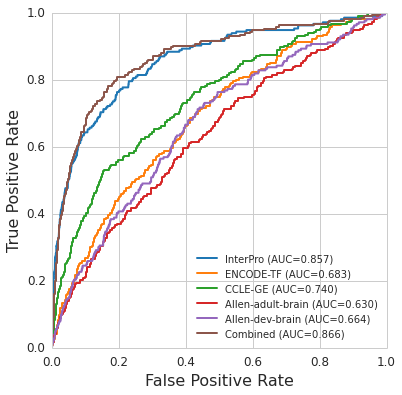

In [15]:
Xs.append(X_combined)
basenames.append('Combined')

# optimized GBM classifiers
xgbc = xgb.XGBClassifier(seed=RNG, n_estimators=39, learning_rate=0.05,
    max_depth=10, colsample_bytree=0.6, subsample=0.4, min_child_weight=50,
    gamma=0, max_delta_step=0, nthread=6, silent=True, scale_pos_weight=ratio)

xgbc2 = xgb.XGBClassifier(seed=RNG, n_estimators=159, learning_rate=0.05,
    max_depth=12, colsample_bytree=0.4, subsample=0.4, min_child_weight=50,
    gamma=0, max_delta_step=0, nthread=6, silent=True, scale_pos_weight=ratio)

clfs = [xgbc] * 5 + [xgbc2]

fig, ax = plt.subplots(figsize=(6,6))
plot_roc(clfs, Xs, y, cv, ax, colors=COLORS10, labels=basenames)

# 3. Apply the GBM classifier to all the datasets to generate predictions 

In [16]:
RNG = 20160628
xgbc2 = xgb.XGBClassifier(seed=RNG, n_estimators=160, learning_rate=0.05,
    max_depth=12, colsample_bytree=0.4, subsample=0.4, min_child_weight=50,
    gamma=0, max_delta_step=0, nthread=8, silent=True, scale_pos_weight=ratio)

cv = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=RNG)

## Get out-of-fold predictions
y_preds, y_probas = cross_val_predictions(xgbc2, X_combined, y, cv)

## Get predictions on training fold
xgbc2.fit(X_combined, y)
y_probas_on_train = xgbc2.predict_proba(X_combined)[:, 1]


(12117, 300) (12117,)
(12117, 300) (12117,)
(12117, 300) (12117,)
(12117, 300) (12117,)
(12117, 300) (12117,)
(12117, 300) (12117,)
(12118, 300) (12118,)
(12118, 300) (12118,)
(12119, 300) (12119,)
(12119, 300) (12119,)


In [17]:
df_labels['OOF_preds'] = y_preds
df_labels['OOF_probas'] = y_probas
df_labels['train_probas'] = y_probas_on_train

df_labels.head()

,GeneSym,y,OOF_preds,OOF_probas,train_probas
0,NUSAP1,0,0,0.024595,0.027813
1,WEE1,0,0,0.040820,0.036656
2,BUB1B,0,0,0.052495,0.024476
3,ASPM,0,0,0.050891,0.046398
4,TTK,0,0,0.092996,0.039838


In [18]:
df_labels.to_csv('../XGB160_on_combined_predictions.csv')

# 4. Inteprete the classifier by feature importances

In [19]:
## Get the feature_importances_ from the fitted GBM
feature_importances = xgbc2.feature_importances_
print feature_importances.shape

(300,)


In [20]:
## Count the number of original features
n_features = sum(map(len, feature_names.values()))
print 'There are %d features across these datasets used for the prediction' % n_features

There are 14637 features across these datasets used for the prediction


Map feature importances on the SVD components back to original feature space by dot product between the feature importance vector and the loading matrix:

In [26]:
all_feature_names = []
all_feature_fis = []
datasets = []
for i, basename in enumerate(basenames[:-1]):
    fi = feature_importances[i*60:(i+1)*60]
    loadings = all_loadings[i]
    original_feature_fis = np.dot(fi, loadings)
    original_feature_names = feature_names[basename]
    
    datasets.extend([basename] * len(original_feature_names))
    all_feature_fis.extend( original_feature_fis.tolist() )
    all_feature_names.extend( original_feature_names )

# Create a DataFrame of feature importances
df_feature_importances = pd.DataFrame({
        'dataset': datasets,
        'feature': all_feature_names, 
        'feature_importance': all_feature_fis})    

Examine the most predictive features for adhesome components:

In [27]:
df_feature_importances.sort('feature_importance', ascending=False).head(20)

,dataset,feature,feature_importance
10351,InterPro,Ubiquitin-related domain,0.008553
7372,InterPro,Protein kinase-like domain,0.007375
875,InterPro,Armadillo-type fold,0.007230
7369,InterPro,Protein kinase domain,0.006197
2466,InterPro,Death-like domain,0.005954
1214,InterPro,C2 domain,0.005682
14582,Allen-dev-brain,primary auditory cortex (core)_3 yrs_M_12980,0.005443
4473,InterPro,Immunoglobulin-like fold,0.005171
6930,InterPro,Pleckstrin homology-like domain,0.005047
10811,InterPro,"Zinc finger, C2H2-like",0.004638


In [28]:
df_feature_importances.to_csv('../feature_importances.csv')